Image Segmentation Evaluation

In [2]:
import os
import json
import numpy as np

import matplotlib.pyplot as plt
import cv2
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

import src.utils as utils

In [ ]:
# NOTE: Run only once
# Download WILD data

SEGMENTATION_DIR = "data/validation/segmentations"

seg_file_1 = "labels_my-project-name_2022-01-23-12-24-03.json"
seg_file_2 = "labels_my-project-name_2022-01-23-01-01-46.json"

# Load json files
with open(os.path.join(SEGMENTATION_DIR, seg_file_1), "r") as f:
    seg_json_1 = json.load(f)

with open(os.path.join(SEGMENTATION_DIR, seg_file_2), "r") as f:
    seg_json_2 = json.load(f)

# Join segmentation jsons
seg_json_full = {}

for key in seg_json_1.keys():
    seg_json_full[key] = seg_json_1[key]

for key in seg_json_2.keys():
    seg_json_full[key] = seg_json_2[key]

# Write json
with open(os.path.join(SEGMENTATION_DIR, "segmentation_annotations.json"), "w+") as f:
    json.dump(seg_json_full, f)

In [3]:
NUM_EVAL_IMAGES = 100
IMAGES_DIR = "data/outputs/activation_maps_v1/images"
SEGMENTATION_DIR = "data/validation/segmentations"
ACTIVATION_MAPS_V1_DIR = "data/outputs/activation_maps_v1/activation_maps"
ACTIVATION_MAPS_V2_DIR = "data/outputs/activation_maps_v2/activation_maps"
BBOXES_DIR = "data/outputs/activation_maps_v1/img_bboxes.json"

# Load activation maps and segmentations
imgs = []
act_maps_v1 = []
act_maps_v2 = []
seg_anns = []
for i, filename in enumerate(os.listdir(ACTIVATION_MAPS_V1_DIR)):
    # Break if reached number of eval images
    if i >= NUM_EVAL_IMAGES:
        break
    
    # Load imgs
    imgs.append(cv2.imread(os.path.join(IMAGES_DIR, "{}.png".format(i))).astype(np.float32)[:,:,0] / 255.)

    # Load act maps
    act_maps_v1.append(cv2.imread(os.path.join(ACTIVATION_MAPS_V1_DIR, filename)).astype(np.float32)[:,:,0] / 255.)
    act_maps_v2.append(cv2.imread(os.path.join(ACTIVATION_MAPS_V2_DIR, filename)).astype(np.float32)[:,:,0] / 255.)

    # Load labels
    with open(os.path.join(SEGMENTATION_DIR, "segmentation_annotations.json"), "r") as f:
        segmentation_annotations = json.load(f)
    
    seg_full = np.zeros(act_maps_v1[-1].shape[:2])
    for seg_i in list(segmentation_annotations[filename]["regions"].keys()):
        x = segmentation_annotations[filename]["regions"][str(seg_i)]["shape_attributes"]["all_points_x"]
        y = segmentation_annotations[filename]["regions"]["0"]["shape_attributes"]["all_points_y"]
        seg = Image.new("RGB", (act_maps_v1[-1].shape[1], act_maps_v1[-1].shape[0]))
        draw = ImageDraw.Draw(seg)
        points = list(zip(x, y))
        draw.polygon((points), fill=200)
        seg = np.asarray(seg)[:,:,0]
        seg_full += seg

    seg_anns.append((seg_full / 255) > 0.5)

# Load bboxes
with open(BBOXES_DIR, "r") as f:
    bboxes = json.load(f)


In [7]:
# Create img masks from bboxes
img_masks = [utils.create_img_bbox_mask(np.zeros(act_map.shape), bboxes[str(i)]) for i, act_map in enumerate(act_maps_v1)]

In [8]:
#### Evaluation functions ####

def standardize(x):
    return x / np.max(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x.astype(np.float32)))

def precision(seg_true, seg_pred):
    intersection = standardize(seg_true.astype(np.float32) * seg_pred.astype(np.float32))
    pred_region = (seg_pred.astype(np.float32) > 0).astype(np.float32)
    if np.sum(intersection) > 0 and np.sum(pred_region) > 0:
        return np.sum(intersection) / np.sum(pred_region)
    return 0

def recall(seg_true, seg_pred):
    intersection = standardize(seg_true.astype(np.float32) * seg_pred.astype(np.float32))
    true_region = (seg_true.astype(np.float32) > 0).astype(np.float32)
    if np.sum(intersection) > 0 and np.sum(true_region) > 0:
        return np.sum(intersection) / np.sum(true_region)
    return 0

def iou(seg_true, seg_pred):
    intersection = standardize(seg_true.astype(np.float32) * seg_pred.astype(np.float32))
    overlap = (seg_true.astype(np.float32) + seg_pred.astype(np.float32) > 0).astype(np.float32)
    if np.sum(intersection) > 0 and np.sum(overlap) > 0:
        return np.sum(intersection) / np.sum(overlap)
    return 0

def evaluate(seg_trues, seg_preds):
    ious = []
    pres = []
    recs = []
    for i in range(len(seg_trues)):
        ious.append(iou(seg_trues[i], seg_preds[i]))
        pres.append(precision(seg_trues[i], seg_preds[i]))
        recs.append(recall(seg_trues[i], seg_preds[i]))
    return sum(ious) / len(pres), sum(pres) / len(recs), sum(recs) / len(recs)

In [53]:
#### Activation Map Processing Functions ####
def fuzzy_cluster(x, cluster_k, blur_k_size, p):
    return utils.cluster_img(cv2.blur(x, (blur_k_size, blur_k_size)) ** p, cluster_k) > np.mean(x)

def high_recall_segmentation(x, mask, t):
    return (x * mask) > (np.mean(x) * t)


In [36]:
def sharpen_img(img, s, b):
    return 1 / (1 + np.exp(-s * (img - np.mean(img) + b)))

# Filter out the small negative regions based on their size
def fill_gaps(img, stride, size_thres, border_size=20):
    img = img.copy()

    # Remove border from image to ensure flooding coverage
    img[:border_size, :] = 0
    img[-border_size:, :] = 0
    img[:,:border_size] = 0
    img[:,-border_size:] = 0

    # Flood outer part of image
    flooded_img = cv2.floodFill(np.float32(img.copy()), None, (0, 0), 1)[1]

    return img + filter_negative_regions(img, 1 - flooded_img, stride, size_thres)

# Filter the negative regions based on its size
def filter_negative_regions(img, negative_regions, stride, size_thres):
    img = img.copy()
    negative_regions = negative_regions.copy()
    large_negative_regions = np.zeros((img.shape[0], img.shape[1]))
    centroids = []
    for i in range(0, img.shape[0], stride):
        for j in range(0, img.shape[1], stride):
            if negative_regions[i, j] == 1:
                selected_region = cv2.floodFill(np.float32(negative_regions.copy()), None, (j, i), 0.5)[1] == 0.5
                if float(selected_region.sum()) > size_thres * img.sum():
                    large_negative_regions += selected_region
                    negative_regions = np.float32(negative_regions > 0) - np.float32(selected_region)
    return negative_regions > 0

def cluster_fill(act_map, stride=10, size_thres=0.01, k=3):
    return fill_gaps((utils.cluster_img(act_map, k) > 0.5).astype(np.float32), stride, size_thres)
    
def erode_segmentation(seg_region, k, n):
    return cv2.erode(np.float32(seg_region), kernel=np.ones((k, k), np.uint8), iterations=n)


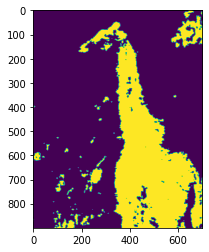

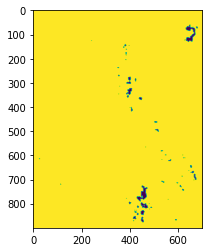

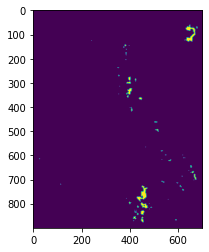

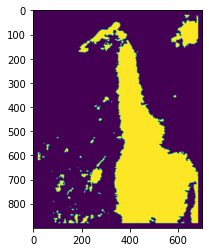

In [50]:
def ex_fill_gaps(img, stride, size_thres, border_size=20):
    img = img.copy()

    # Remove border from image to ensure flooding coverage
    img[:border_size, :] = 0
    img[-border_size:, :] = 0
    img[:,:border_size] = 0
    img[:,-border_size:] = 0

    # Flood outer part of image
    flooded_img = cv2.floodFill(np.float32(img.copy()), None, (0, 0), 1)[1]

    plt.imshow(flooded_img)
    plt.show()

    plt.imshow(-flooded_img)
    plt.show()

    return img + filter_negative_regions(img, 1 - flooded_img, stride, size_thres)

c = utils.cluster_img(act_maps_v1[25], k=3) > 0.5
plt.imshow(c)
plt.show()

plt.imshow(ex_fill_gaps(c, stride=10, size_thres=0.1, border_size=20))
plt.show()

In [54]:
# Get masked act maps
masked_act_maps = [mask * act_map for mask, act_map in zip(img_masks, act_maps_v1)]

# Get binary masked act maps
bin_act_maps = [(act_map > 0.5) for act_map in masked_act_maps]

# Get clustered act maps
clustered_act_maps = [mask * (utils.cluster_img(act_map, 3) > 0.5).astype(np.float32) for mask, act_map in zip(img_masks, masked_act_maps)]

# Get binary masked act maps
blur_clustered_act_maps = [mask * fuzzy_cluster(act_map, cluster_k=3, blur_k_size=16, p=2) for mask, act_map in zip(img_masks, masked_act_maps)]

# Get high recall act maps
high_recall_act_maps = [high_recall_segmentation(act_maps_v2[i], img_masks[i], t=1) for i in range(len(act_maps_v2))]

# Get clustered act maps with negative regions filled
clustered_filled_act_maps = [erode_segmentation(img_mask * cluster_fill(act_map, stride=10, size_thres=0.02, k=3), 8, 2) for act_map, img_mask in zip(act_maps_v2, img_masks)]

In [55]:
print("Activation Maps\n", evaluate(seg_anns, act_maps_v1), "\n")

print("Predicted Regions\n", evaluate(seg_anns, act_maps_v2), "\n")

print("Masked Activation Maps\n", evaluate(seg_anns, masked_act_maps), "\n")

print("Binary M. Activation Maps\n", evaluate(seg_anns, bin_act_maps), "\n")

print("Clustered M. Activation Maps\n", evaluate(seg_anns, clustered_act_maps), "\n")

print("Blur Clustered M. Activation Maps\n", evaluate(seg_anns, blur_clustered_act_maps), "\n")

print("High Recall Activation Maps\n", evaluate(seg_anns, high_recall_act_maps), "\n")

print("Clustered Filled Activation Maps\n", evaluate(seg_anns, clustered_filled_act_maps), "\n")

Activation Maps
 (0.11869272721465678, 0.11876953443046659, 0.685275805592537) 

Predicted Regions
 (0.13723763359244912, 0.13739826092030852, 0.8400136649608612) 

Masked Activation Maps
 (0.23040440503507853, 0.2313324999809265, 0.6834049743413925) 

Binary M. Activation Maps
 (0.5555024983733893, 0.6483713813871145, 0.8014984630048275) 

Clustered M. Activation Maps
 (0.5164825656637549, 0.5631910439953208, 0.9029662781953811) 

Blur Clustered M. Activation Maps
 (0.5179532461613416, 0.5430148564279079, 0.9324480521678925) 

High Recall Activation Maps
 (0.46221456792205573, 0.48196434885263445, 0.9270247393846511) 

Clustered Filled Activation Maps
 (0.5473291994258761, 0.6182736150734126, 0.8486344112455845) 



### Output Samples

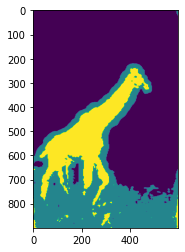

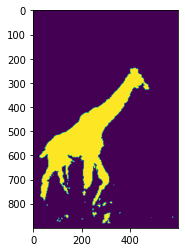

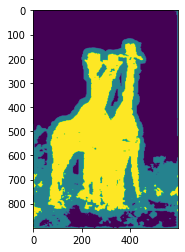

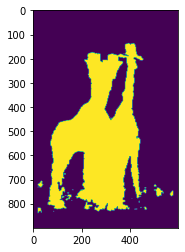

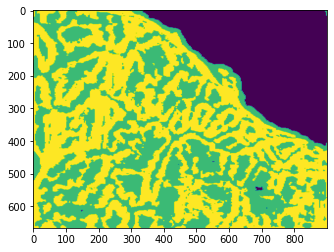

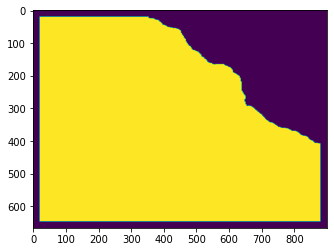

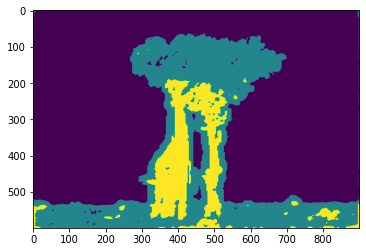

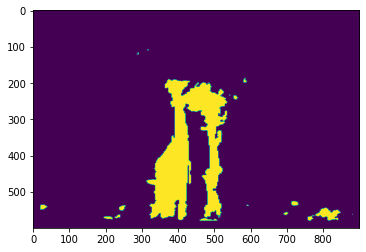

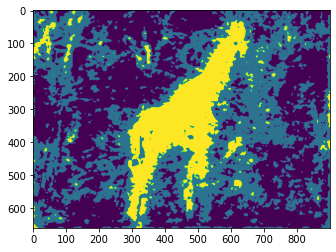

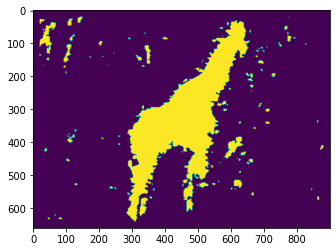

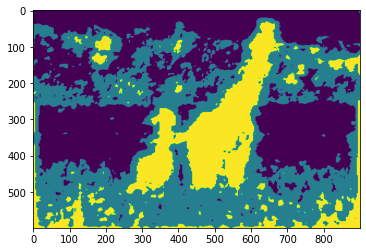

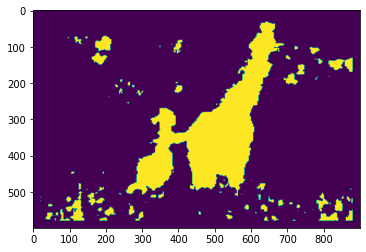

In [52]:
for i in range(0, 6):
    plt.imshow(utils.cluster_img(act_maps_v1[i], k=3))
    plt.show()

    plt.imshow(cluster_fill(act_maps_v1[i], stride=10, size_thres=0.05, k=3))
    plt.show()

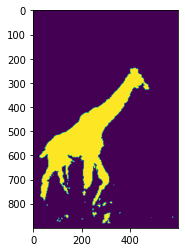

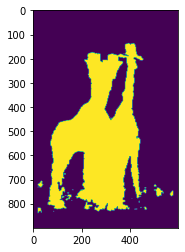

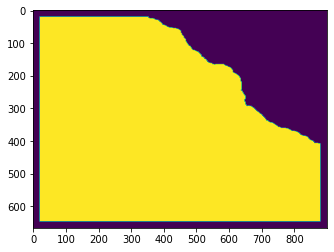

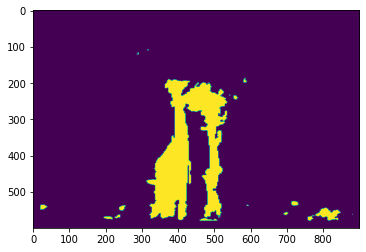

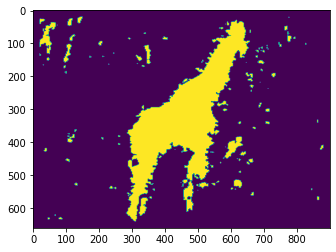

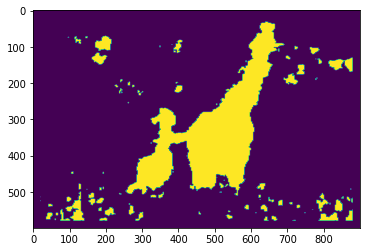

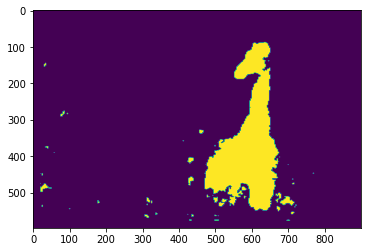

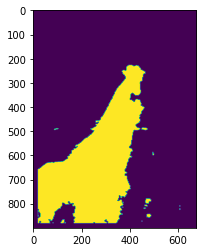

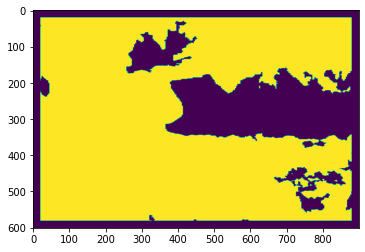

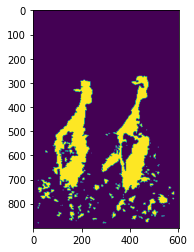

In [37]:
for i in range(0, 10):
    plt.imshow(cluster_fill(act_maps_v1[i], stride=10, size_thres=0.02, k=3))
    plt.show()

In [ ]:
for i in range(0, 30):
    print("\n------------------------", i, "------------------------\n")

    print("Image")
    plt.imshow(imgs[i])
    plt.show()

    print("Clustered Act Map")
    plt.imshow(clustered_act_maps[i])
    plt.show()

    plt.imshow(clustered_filled_act_maps[i])
    plt.show()

    print("Segmentation Ground Truth")
    plt.imshow(seg_anns[i])
    plt.show()

In [ ]:
# 4, 8, 15, 18, 29, 76
def fuzzy_cluster(x, cluster_k, blur_k_size, p):
    return cluster_img(cv2.blur(x, (blur_k_size, blur_k_size)) ** p, cluster_k) > np.mean(x)
    
i = 76

plt.imshow(act_maps[i])
plt.show()

plt.imshow(cluster_img(act_maps[i].copy(), 2))
plt.show()

plt.imshow(fuzzy_cluster(act_maps[i].copy()))
plt.show()